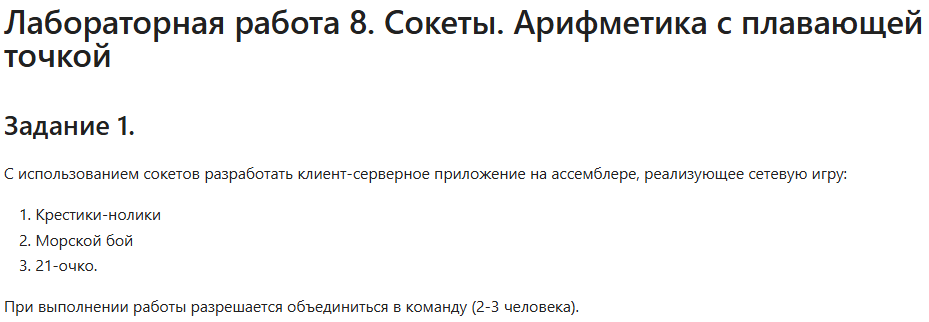

# Задача 3: 21-очко

In [ ]:
client.asm

In [ ]:
format ELF64
public _start

SYS_READ        = 0
SYS_WRITE       = 1
SYS_CLOSE       = 3
SYS_SOCKET      = 41
SYS_CONNECT     = 42
SYS_EXIT        = 60
AF_INET         = 2
SOCK_STREAM     = 1

section '.data' writeable
    msg_conn        db 'Connecting to localhost...', 10, 0

    serv_addr:
        dw AF_INET
        db 0x1E, 0x61       ; Port 7777
        db 127,0,0,1        ; IP 127.0.0.1
        dq 0

    sockfd          dq 0
    recv_buf        rb 512
    input_char      db 0

section '.text' executable
_start:
    mov rsi, msg_conn
    call print_string

    mov rax, SYS_SOCKET
    mov rdi, AF_INET
    mov rsi, SOCK_STREAM
    mov rdx, 0
    syscall
    mov [sockfd], rax

    mov rax, SYS_CONNECT
    mov rdi, [sockfd]
    mov rsi, serv_addr
    mov rdx, 16
    syscall

loop_game:
    ; 1. Читаем что прислал сервер
    mov byte [recv_buf], 0
    mov rax, SYS_READ
    mov rdi, [sockfd]
    mov rsi, recv_buf
    mov rdx, 511
    syscall

    cmp rax, 0
    jle do_exit         ; Если 0 байт - сервер закрыл игру (конец)

    ; Печатаем ответ сервера
    mov rdx, rax
    mov rax, SYS_WRITE
    mov rdi, 1
    syscall

    ; 2. Читаем ввод с клавиатуры
    mov rax, SYS_READ
    mov rdi, 0          ; stdin
    mov rsi, input_char
    mov rdx, 2          ; символ + энтер
    syscall

    ; 3. Отправляем на сервер только первый байт
    mov rax, SYS_WRITE
    mov rdi, [sockfd]
    mov rsi, input_char
    mov rdx, 1
    syscall

    jmp loop_game

do_exit:
    mov rax, SYS_CLOSE
    mov rdi, [sockfd]
    syscall
    mov rax, SYS_EXIT
    xor rdi, rdi
    syscall

; Хелперы
print_string:
    push rdi
    push rax
    push rdx
    push rcx
    mov rdi, rsi
    call strlen
    mov rdx, rax
    mov rax, SYS_WRITE
    mov rdi, 1
    syscall
    pop rcx
    pop rdx
    pop rax
    pop rdi
    ret

strlen:
    xor rax, rax
.L: cmp byte [rdi + rax], 0
    je .D
    inc rax
    jmp .L
.D: ret


In [ ]:
server.asm

In [ ]:

format ELF64
public _start

SYS_WRITE       = 1
SYS_CLOSE       = 3
SYS_SOCKET      = 41
SYS_ACCEPT      = 43
SYS_BIND        = 49
SYS_LISTEN      = 50
SYS_EXIT        = 60

AF_INET         = 2
SOCK_STREAM     = 1
INADDR_ANY      = 0
PORT            = 7777

section '.data' writeable
    msg_start       db '[Server] BLACKJACK (Visual) ready on 7777...', 10, 0
    msg_client      db '[Client connected]', 10, 0
    msg_bye         db '--- SESSION CLOSED ---', 10, 0

    recv_buf        rb 256
    send_buf        rb 1024

    serv_addr:
        dw AF_INET
        db 0x1E, 0x61       ; Port 7777
        dd INADDR_ANY
        dq 0

    sockfd          dq 0
    clientfd        dq 0

    player_score    dq 0
    player_aces     dq 0
    dealer_score    dq 0
    dealer_aces     dq 0
    dealer_open_val dq 0

    ; Хранилище карт на руках (максимум 10 карт)
    ; Храним ASCII символы карт ('A', 'K', '2'...)
    player_hand     rb 20
    player_hand_len dq 0

    dealer_hand     rb 20
    dealer_hand_len dq 0

    deck_index      dq 0
    seed            dq 123456789

    ; Имена карт для отображения
    card_names      db '2','3','4','5','6','7','8','9','T','J','Q','K','A'

    card_values     db 2,2,2,2, 3,3,3,3, 4,4,4,4, 5,5,5,5, 6,6,6,6, 7,7,7,7, 8,8,8,8, 9,9,9,9
                    db 10,10,10,10 ; 10
                    db 10,10,10,10 ; J
                    db 10,10,10,10 ; Q
                    db 10,10,10,10 ; K
                    db 11,11,11,11 ; A

    deck            db 52 dup(0)

section '.text' executable
_start:
    ; Init Deck
    mov rcx, 52
    xor rax, rax
    .init:
        mov [deck + rax], al
        inc rax
        loop .init

        ; Net
        mov rax, SYS_SOCKET
        mov rdi, AF_INET
        mov rsi, SOCK_STREAM
        mov rdx, 0
        syscall
        mov [sockfd], rax

        mov rax, SYS_BIND
        mov rdi, [sockfd]
        mov rsi, serv_addr
        mov rdx, 16
        syscall

        mov rax, SYS_LISTEN
        mov rdi, [sockfd]
        mov rsi, 1
        syscall

        mov rsi, msg_start
        call print_string

accept_loop:
    mov rax, SYS_ACCEPT
    mov rdi, [sockfd]
    mov rsi, 0
    mov rdx, 0
    syscall
    mov [clientfd], rax

    mov rsi, msg_client
    call print_string

new_game_start:
    mov qword [player_score], 0
    mov qword [player_aces], 0
    mov qword [dealer_score], 0
    mov qword [dealer_aces], 0
    mov qword [deck_index], 0

    mov qword [player_hand_len], 0
    mov qword [dealer_hand_len], 0

    call shuffle_deck

    ; Раздача
    mov rdi, 0
    call give_card_smart
    mov rdi, 0
    call give_card_smart

    mov rdi, 1
    call give_card_smart
    mov rax, [dealer_score]
    mov [dealer_open_val], rax
    mov rdi, 1
    call give_card_smart

    cmp qword [player_score], 21
    je check_dealer_bj

    call send_status_hidden

game_loop:
    mov rax, 0
    mov rdi, [clientfd]
    mov rsi, recv_buf
    mov rdx, 255
    syscall

    cmp rax, 0
    jle close_client

    mov al, byte [recv_buf]

    cmp al, '1'      ; Hit
    je hit_me

    cmp al, '2'      ; Stand
    je stand

    cmp al, '3'      ; Restart
    je new_game_start

    cmp al, '4'      ; EXIT
    je close_client_graceful

    jmp game_loop

hit_me:
    mov rdi, 0
    call give_card_smart
    cmp qword [player_score], 21
    jg player_bust
    call send_status_hidden
    jmp game_loop

check_dealer_bj:
    cmp qword [dealer_score], 21
    je result_draw_bj
    jmp result_win_bj

stand:
dealer_turn:
    cmp qword [dealer_score], 17
    jge dealer_done
    mov rdi, 1
    call give_card_smart
    jmp dealer_turn

dealer_done:
    mov rax, [dealer_score]
    cmp rax, 21
    jg result_win_dealer_bust
    mov rbx, [player_score]
    cmp rbx, rax
    jg result_win
    jl result_lose
    je result_draw

; --- ИСХОДЫ ---
player_bust:
    mov rdi, send_buf
    call draw_header
    call w_bust
    jmp send_final

result_win_bj:
    mov rdi, send_buf
    call draw_header
    call w_bj
    jmp send_final

result_draw_bj:
    mov rdi, send_buf
    call draw_header
    call w_push
    jmp send_final


result_win:
    mov rdi, send_buf
    call draw_header
    call w_win
    jmp send_final

result_win_dealer_bust:
    mov rdi, send_buf
    call draw_header
    call w_win_db
    jmp send_final

result_lose:
    mov rdi, send_buf
    call draw_header
    call w_lose
    jmp send_final

result_draw:
    mov rdi, send_buf
    call draw_header
    call w_push
    jmp send_final

send_final:
    mov rsi, send_buf
    call send_string
    ; НЕ прыгаем в game_loop, а идем в спец. цикл ожидания
    jmp restart_loop

restart_loop:
    mov rax, 0
    mov rdi, [clientfd]
    mov rsi, recv_buf
    mov rdx, 255
    syscall

    cmp rax, 0
    jle close_client

    mov al, byte [recv_buf]

    cmp al, '3'      ; Restart
    je new_game_start

    cmp al, '4'      ; Exit
    je close_client_graceful

    ; Любые другие кнопки (1, 2) просто игнорируем
    jmp restart_loop

close_client_graceful:
    mov rsi, msg_bye
    call send_string

close_client:
    mov rax, SYS_CLOSE
    mov rdi, [clientfd]
    syscall
    jmp accept_loop

; --- ФУНКЦИИ ---
give_card_smart:
    push rbx
    push rcx
    push rdx

    mov rbx, [deck_index]
    movzx rax, byte [deck + rbx]
    inc [deck_index]

    ; --- СОХРАНЕНИЕ КАРТЫ ---
    push rax
    ; Вычисляем имя (индекс / 4)
    push rdx
    xor rdx, rdx
    mov rbx, 4
    div rbx ; rax = 0..12
    mov bl, [card_names + rax]
    pop rdx

    cmp rdi, 0
    je .save_player
    jmp .save_dealer

    .save_player:
        mov rdx, [player_hand_len]
        mov [player_hand + rdx], bl
        inc [player_hand_len]
        jmp .save_done
    .save_dealer:
        mov rdx, [dealer_hand_len]
        mov [dealer_hand + rdx], bl
        inc [dealer_hand_len]
    .save_done:
        pop rax
        ; ------------------------

        movzx rcx, byte [card_values + rax]

        cmp rdi, 0
        je .player
        jmp .dealer
    .player:
        add [player_score], rcx
        cmp rcx, 11
        jne .p_check
        inc [player_aces]
    .p_check:
        cmp qword [player_score], 21
        jle .done
        cmp qword [player_aces], 0
        je .done
        sub qword [player_score], 10
        dec qword [player_aces]
        jmp .p_check
    .dealer:
        add [dealer_score], rcx
        cmp rcx, 11
        jne .d_check
        inc [dealer_aces]
    .d_check:
        cmp qword [dealer_score], 21
        jle .done
        cmp qword [dealer_aces], 0
        je .done
        sub qword [dealer_score], 10
        dec qword [dealer_aces]
        jmp .d_check
    .done:
        pop rdx
        pop rcx
        pop rbx
        ret

; --- UI ---
draw_header:
    mov byte [rdi], 10
    inc rdi
    mov dword [rdi], '===='
    mov dword [rdi+4], '===='
    add rdi, 8
    mov byte [rdi], 10
    inc rdi
    ret

; ФУНКЦИЯ ОТРИСОВКИ РУКИ (ВСЕХ КАРТ)
; RSI - указатель на массив, RCX - длина
draw_cards:
    push rbx
    push rcx
    push rsi

    xor rbx, rbx
    .loop:
        cmp rbx, rcx
        jge .end

        mov byte [rdi], '['
        inc rdi
        mov al, [rsi + rbx]
        mov [rdi], al
        inc rdi
        mov byte [rdi], ']'
        inc rdi

        inc rbx
        jmp .loop
    .end:
        pop rsi
        pop rcx
        pop rbx
        ret

send_status_hidden:
    mov rdi, send_buf
    call draw_header

    ; DEALER
    mov dword [rdi], 'DEAL'
    mov dword [rdi+4], 'ER: '
    add rdi, 8
    mov rax, [dealer_open_val]
    call int_to_buf
    mov dword [rdi], '   ' ; пробел
    add rdi, 3

    ; Рисуем только ПЕРВУЮ карту дилера + [?]
    mov byte [rdi], '['
    inc rdi
    mov al, [dealer_hand]
    mov [rdi], al
    inc rdi
    mov dword [rdi], '][?]'
    add rdi, 4

    mov byte [rdi], 10
    inc rdi

    ; PLAYER
    mov dword [rdi], 'YOU:'
    mov byte [rdi+4], ' '
    add rdi, 5
    mov rax, [player_score]
    call int_to_buf
    mov dword [rdi], '   '
    add rdi, 3

    ; Рисуем ВСЕ карты игрока
    mov rsi, player_hand
    mov rcx, [player_hand_len]
    call draw_cards

    mov byte [rdi], 10
    inc rdi


    mov dword [rdi], '----'
    mov dword [rdi+4], '----'
    add rdi, 8
    mov byte [rdi], 10
    inc rdi

    mov dword [rdi], '[1] '
    mov dword [rdi+4], 'HIT '
    add rdi, 8
    mov dword [rdi], '[2] '
    mov dword [rdi+4], 'STAN'
    mov byte [rdi+8], 'D'
    add rdi, 9
    mov byte [rdi], 0

    mov rsi, send_buf
    call send_string
    ret

; ФИНАЛЬНЫЙ ЭКРАН (ВИДНЫ ВСЕ КАРТЫ)
append_full_stats:
    mov byte [rdi], 10
    inc rdi

    ; YOU
    mov dword [rdi], 'You:'
    mov byte [rdi+4], ' '
    add rdi, 5
    mov rax, [player_score]
    call int_to_buf
    mov byte [rdi], ' '
    inc rdi
    mov rsi, player_hand
    mov rcx, [player_hand_len]
    call draw_cards

    mov byte [rdi], 10
    inc rdi

    ; DEALER
    mov dword [rdi], 'Deal'
    mov word [rdi+4], 'er'
    mov word [rdi+6], ': '
    add rdi, 8
    mov rax, [dealer_score]
    call int_to_buf
    mov byte [rdi], ' '
    inc rdi
    mov rsi, dealer_hand
    mov rcx, [dealer_hand_len]
    call draw_cards

    mov byte [rdi], 10
    inc rdi
    mov dword [rdi], '===='
    mov dword [rdi+4], '===='
    add rdi, 8

    ; Menu
    mov byte [rdi], 10
    inc rdi
    mov dword [rdi], '[3] '
    mov dword [rdi+4], 'AGAI'
    mov dword [rdi+8], 'N   '
    add rdi, 12
    mov dword [rdi], '[4] '
    mov dword [rdi+4], 'EXIT'
    add rdi, 8

    mov byte [rdi], 0
    ret

; MESSAGES
w_bj:
    mov dword [rdi], '$$$ '
    mov dword [rdi+4], 'BLAC'
    mov dword [rdi+8], 'KJAC'
    mov dword [rdi+12], 'K! $'
    mov dword [rdi+16], '$$  '
    add rdi, 18
    jmp append_full_stats
w_bust:
    mov dword [rdi], '--- '
    mov dword [rdi+4], 'BUST'
    mov dword [rdi+8], 'ED -'
    mov dword [rdi+12], '--  '
    add rdi, 14
    jmp append_full_stats
w_win:
    mov dword [rdi], '*** '
    mov dword [rdi+4], 'YOU '
    mov dword [rdi+8], 'WIN '
    mov dword [rdi+12], '*** '
    add rdi, 16
    jmp append_full_stats
w_win_db:
    mov dword [rdi], '*** '
    mov dword [rdi+4], 'WIN '
    mov dword [rdi+8], '(D.B'
    mov dword [rdi+12], 'UST)'
    mov dword [rdi+16], ' ***'
    add rdi, 20
    jmp append_full_stats
w_lose:
    mov dword [rdi], '--- '
    mov dword [rdi+4], 'LOSE'
    mov dword [rdi+8], ' ---'
    add rdi, 12
    jmp append_full_stats
w_push:
    mov dword [rdi], '=== '
    mov dword [rdi+4], 'PUSH'
    mov dword [rdi+8], ' ==='
    add rdi, 12
    jmp append_full_stats

int_to_buf:
    push rbx
    push rdx
    mov rbx, 10
    xor rdx, rdx
    div rbx
    add al, '0'
    add dl, '0'
    mov [rdi], al
    inc rdi
    mov [rdi], dl
    inc rdi
    pop rdx
    pop rbx
    ret

shuffle_deck:
    mov rcx, 51
    .sh:
        push rcx
        call rand
        xor rdx, rdx
        mov rbx, 52
        div rbx
        pop rcx
        mov al, [deck + rcx]
        mov ah, [deck + rdx]
        mov [deck + rcx], ah
        mov [deck + rdx], al
        loop .sh
        ret

rand:
    push rbx
    push rcx
    push rdx
    mov rax, [seed]
    mov rbx, 6364136223846793005
    mul rbx
    mov rcx, 1442695040888963407
    add rax, rcx
    mov [seed], rax
    pop rdx
    pop rcx
    pop rbx
    ret

send_string:
    push rdi
    push rax
    push rdx
    push rcx
    mov rdi, rsi
    call strlen
    mov rdx, rax
    mov rax, SYS_WRITE
    mov rdi, [clientfd]
    syscall
    pop rcx
    pop rdx
    pop rax
    pop rdi
    ret

print_string:
    push rdi
    push rax
    push rdx
    push rcx
    mov rdi, rsi
    call strlen
    mov rdx, rax
    mov rax, SYS_WRITE
    mov rdi, 1
    syscall
    pop rcx
    pop rdx
    pop rax
    pop rdi
    ret

strlen:
    xor rax, rax
    .L: cmp byte [rdi + rax], 0
        je .D
        inc rax
        jmp .L
    .D: ret


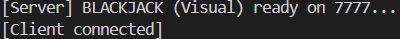

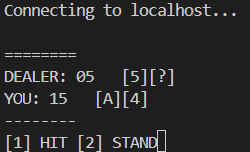

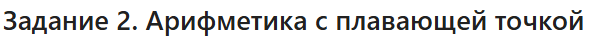

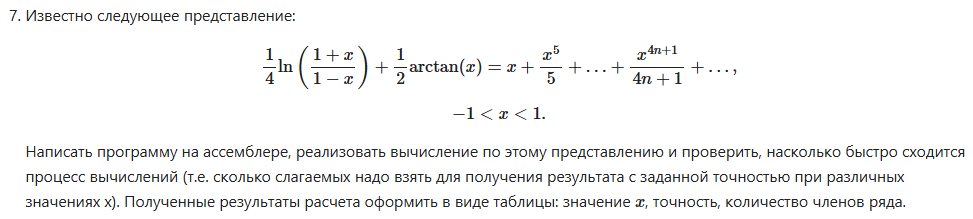

In [ ]:
format ELF64
public _start

extrn printf
extrn scanf
extrn exit

SYS_EXIT        = 60
EXIT_SUCCESS    = 0

section '.data' writeable
    input_fmt       db "%lf", 0
    output_header   db "%-10s%-15s%-15s", 10, 0
    output_row      db "%-10.6f%-15.6f%-15d", 10, 0

    str_x           db "x", 0
    str_eps         db "epsilon", 0
    str_terms       db "terms", 0

    msg_prompt_x    db "Enter x (-1 < x < 1): ", 0
    msg_prompt_eps  db "Enter epsilon: ", 0
    msg_newline     db 10, 0

    val_1_0         dq 1.0
    val_4_0         dq 4.0

    x               rq 1        ; входной x
    epsilon         rq 1        ; точность
    result          rq 1        ; сумма ряда
    term_count      rq 1        ; счетчик итераций
    current_term    rq 1        ; текущий член ряда
    temp            rq 1        ; временный буфер
    x_power         rq 1        ; степень x

section '.text' executable

_start:
    mov rdi, msg_prompt_x
    xor rax, rax
    call printf

    mov rdi, input_fmt
    mov rsi, x
    xor rax, rax
    call scanf

    mov rdi, msg_prompt_eps
    xor rax, rax
    call printf

    mov rdi, input_fmt
    mov rsi, epsilon
    xor rax, rax
    call scanf

    finit
    fld qword [x]
    fabs                    ; st0 = |x|
    fld1                    ; st0 = 1, st1 = |x|
    fcomip st1
    fstp st0                ; очистка стека
    jbe .invalid_input      ; если 1 <= |x|

    ; Расчеты
    call calc_analytic      ; результат в st0 -> temp
    fstp qword [temp]       ; сохраняем для (возможного) использования

    call calc_series        ; результат в [result]

    ; Вывод заголовка
    mov rdi, output_header
    mov rsi, str_x
    mov rdx, str_eps
    mov rcx, str_terms
    xor rax, rax
    call printf

    ; Вывод строки с данными
    mov rdi, output_row
    movq xmm0, [x]
    movq xmm1, [epsilon]
    mov rsi, [term_count]
    mov rax, 2              ; 2 float аргумента в xmm
    call printf

    ; Выход
    mov rax, SYS_EXIT
    xor rdi, rdi
    syscall

    .invalid_input:
        mov rdi, msg_newline
        call printf
        mov rdi, msg_newline
        call printf

        mov rax, SYS_EXIT
        mov rdi, 1
        syscall


calc_analytic:
    push rbp
    mov rbp, rsp

    ; (1/4) * ln((1+x)/(1-x))
    fld1
    fadd qword [x]          ; st0 = 1 + x
    fld1
    fsub qword [x]          ; st0 = 1 - x
    fdivp st1, st0          ; st0 = (1+x)/(1-x)
    fyl2x                   ; st0 = log2(...)
    fldln2
    fmulp st1, st0          ; st0 = ln(...)

    fld qword [val_1_0]
    fld qword [val_4_0]
    fdivp st1, st0          ; st0 = 0.25
    fmulp st1, st0          ; st0 = 0.25 * ln(...)

    ; (1/2) * arctan(x)
    fld qword [x]
    fld1
    fpatan                  ; st0 = arctan(x)

    fld1
    fadd st0, st0           ; st0 = 2.0
    fdivrp st1, st0         ; st0 = arctan(x) / 2

    ; Sum
    faddp st1, st0

    leave
    ret


; Вычисление ряда: x + x^5/5 + x^9/9 ...
calc_series:
    push rbp
    mov rbp, rsp

    finit
    fldz
    fstp qword [result]

    mov qword [term_count], 0
    mov qword [x_power], 1  ; инициализация для логики степеней

    ; Базовая инициализация для первой итерации
    fld qword [x]
    fstp qword [current_term]
    fld qword [x]
    fstp qword [x_power]

    .loop:
        inc qword [term_count]

        finit
        fld qword [x_power]

        fld qword [x]
        fmul st0, st0           ; x^2
        fmul st0, st0           ; x^4
        fmulp st1, st0          ; x^(old + 4)
        fst qword [x_power]     ; сохранили новую степень

        ; Делитель (4n + 1)
        fild qword [term_count]
        fld qword [val_4_0]
        fmulp st1, st0          ; 4n
        fld1
        faddp st1, st0          ; 4n + 1

        fdivp st1, st0          ; x^(4n+1) / (4n+1)
        fst qword [current_term]

        ; Суммирование
        fadd qword [result]
        fstp qword [result]

        ; Проверка точности |term| < epsilon
        fld qword [current_term]
        fabs
        fld qword [epsilon]
        fcomip st1
        fstp st0
        jb .next_iter           ; epsilon < |term| продолжаем
        jmp .done

    .next_iter:
        cmp qword [term_count], 1000000
        jl .loop

    .done:
        leave
        ret


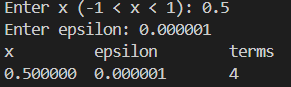